<a href="https://colab.research.google.com/github/mariel0503/aprendizaje-automatico-252601/blob/main/4_8_M%C3%A9todo_de_clustering_espectral_Milan_Mariel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 **Taller 4.8: Taller de Método de Clustering Espectral**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a poner en práctica los conceptos vistos en clase relacionados con los métodos de clustering espectral

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix, diags, eye, issparse
from scipy import linalg

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

Cargamos el dataset reducido, para probar este algoritmo

✅ Dataset cargado desde URL GitHub


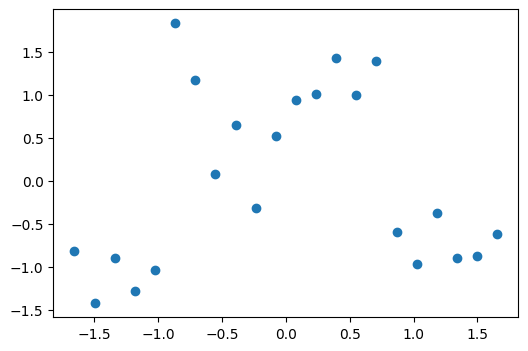

In [3]:
D =cargar_dataset("dataset_reducido.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False),:]
Dx = D[:,:2]

from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
Dx = scaler.fit_transform(Dx)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1])

# 🎯 **1:Cree el Algoritmo de Clustering Espectral**

## PASO 1: GRAFO DE SIMILITUD


### Metodo para Graficar un Grafo de Similitud


In [9]:
def plt_grafo_afinidad(Dx, A):
    # Verificar si hay conexiones
    # Normalizar pesos para grosor
    non_zero_mask = A > 0
    non_zero_vals = A[non_zero_mask]

    min_val = np.min(non_zero_vals)
    max_val = np.max(non_zero_vals)

    # Evitar división por cero
    if max_val - min_val == 0:
        aux = np.ones_like(non_zero_vals) * 0.5
    else:
        aux = (non_zero_vals - min_val) / (max_val - min_val)

    # Grosor entre 0.5 y 5
    W_scaled = 0.5 + 4.5 * aux

    # Crear matriz de grosores
    W = np.zeros_like(A, dtype=float)
    W[non_zero_mask] = W_scaled

    # Crear figura
    fig, ax = plt.subplots(figsize=(6, 4))

    # Puntos
    ax.scatter(Dx[:, 0], Dx[:, 1], s=80, c='blue', alpha=0.7)
    for i in range(Dx.shape[0]):
        ax.annotate(str(i),
                   xy=(Dx[i, 0], Dx[i, 1]),  # ¡IMPORTANTE: tupla (x, y)!
                   xytext=(3, 3),
                   textcoords='offset points')
    inds = np.where(A > 0)
    for i in range(len(inds[0])):
        idx1 = inds[0][i]
        idx2 = inds[1][i]
        # Solo graficar una vez por par (i < j)
        if idx1 < idx2:
            ax.plot([Dx[idx1, 0], Dx[idx2, 0]],
                   [Dx[idx1, 1], Dx[idx2, 1]],
                   linestyle='-',
                   linewidth=W[idx1, idx2],
                   c='red',
                   alpha=0.5)
    ax.set_title(f'Grafo de Afinidad ({len(inds[0])//2} conexiones)')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### a)	El grafo ε-vecindad

In [10]:
def grafo_epsilon(Dx, epsilon, sigma=None):
    #sigma: si es None, grafo binario; si es float, pesos gaussianos
    n = Dx.shape[0]
    distancias = euclidean_distances(Dx)
    # Máscara binaria: 1 si distancia < epsilon
    mascara = (distancias<epsilon).astype(float)# p1 tu codigo aqui
    np.fill_diagonal(mascara, 0)  # eliminar self-loops, No queremos que un nodo cercano de si mismo
    if sigma is None:
        # Grafo binario
        W = mascara
    else:
        # Grafo con pesos gaussianos dentro de epsilon
        W = np.exp(-distancias**2 / (2 * sigma**2))
        W = W*mascara# p2 tu codigo aqui
        np.fill_diagonal(W, 0)
    return W

#### Selección de ε (epsilon) y σ (sigma) en la Construcción del Grafo
1. Para ε (epsilon) - Radio de Vecindad

In [11]:
distancias = euclidean_distances(Dx)
n = distancias.shape[0]
distancias_vals = distancias[np.triu_indices(n, k=1)]
epsilon = np.median(distancias_vals)

print(f"Método: Mediana")
print(f"  Epsilon sugerido: {epsilon:.4f}")
print(f"  Proporción de conexiones: {np.mean(distancias_vals <= epsilon):.2%}")

Método: Mediana
  Epsilon sugerido: 1.9545
  Proporción de conexiones: 50.22%


2. Para σ (sigma) - Ancho del Kernel Gaussiano

In [12]:
mascara = distancias < epsilon
distancias_filtradas = distancias[mascara]
sigma = np.median(distancias_filtradas[distancias_filtradas > 0])
print(f"Sigma sugerido: {sigma:.4f}")

Sigma sugerido: 1.1317


In [13]:
W = grafo_epsilon(Dx, epsilon, sigma=sigma)# p3 tu codigo aqui

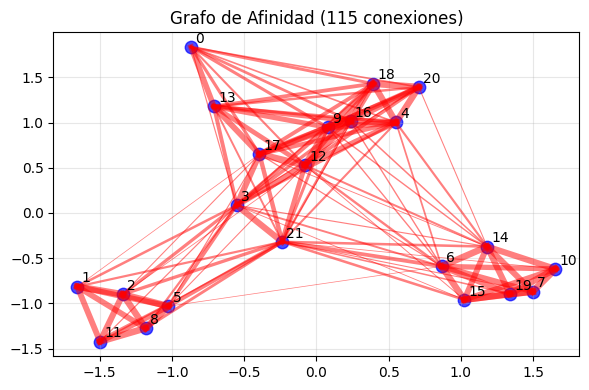

In [14]:
plt_grafo_afinidad(Dx, W)

### b)	El grafo k-Vecinos Más Cercanos (k-NN)

In [15]:
def grafo_knn(Dx, knn, sigma=None, modo='interseccion'):
    n = Dx.shape[0]
    distancias = euclidean_distances(Dx)
    W_dir = np.zeros((n, n))
    # Construir grafo dirigido de k-NN
    for i in range(n):
        # Índices de los k vecinos más cercanos (excluyendo i)
        indices = np.argsort(distancias[i])[1:knn+1]
        if sigma is None:  # Binario
            W_dir[i, indices] = 1
        else: # Gaussiano
            for j in indices:
                d = distancias[i, j]
                W_dir[i, j] = np.exp(-d**2 / (2 * sigma**2))
    # Aplicar modo de simetría
    if modo == 'dirigido':
        W = W_dir
    elif modo == 'union': # Unión: i-j conectados si i→j O j→i
        W = np.maximum(W_dir, W_dir.T)
    elif modo == 'interseccion': # i-j conectados solo si i→j Y j→i
        W = W_dir * W_dir.T
    elif modo == 'mutuo':  # verifica explícitamente vecindad mutua
        W = np.zeros((n, n))
        for i in range(n):
            vecinos_i = np.where(W_dir[i] > 0)[0]
            for j in vecinos_i:
                if W_dir[j, i] > 0:  # j también tiene a i como vecino
                    W[i, j] = W_dir[i, j]
        W = np.maximum(W, W.T)  # hacer simétrico
    np.fill_diagonal(W, 0)# Eliminar self-loops
    return W

#### 1. Para k (número de vecinos)

##### a) Regla logarítmica (para datos bien comportados):

In [16]:
n = Dx.shape[0]
k_base = int(np.log2(n)) + 1  # Mínimo razonable
k_max = int(np.sqrt(n))       # Máximo razonable
k_recomendado = min(max(k_base, 5), k_max)  # Entre 5 y sqrt(n)
print(f"k recomendado: {k_recomendado}")

k recomendado: 4


##### b) Basado en la dimensionalidad intrínseca:

In [17]:
def estimar_k_por_dimensionalidad(Dx, muestra=1000):
    if len(Dx) > muestra:
        indices = np.random.choice(len(Dx), muestra, replace=False)
        muestra_datos = Dx[indices]
    else:
        muestra_datos = Dx
    n_vecinos = 10  # Para estimación inicial
    neigh = NearestNeighbors(n_neighbors=n_vecinos+1)
    neigh.fit(muestra_datos)
    distancias, _ = neigh.kneighbors(muestra_datos)
    # Estimación simple de dimensionalidad local
    # Ratio entre distancias a vecinos consecutivos
    ratios = distancias[:, 2:] / (distancias[:, 1:-1] + 1e-10)
    dim_estimada = 1 / (np.log(ratios).mean(axis=1).mean())
    # k proporcional a dimensionalidad
    k = int(dim_estimada * 5)  # Factor empírico
    return max(5, min(k, int(np.sqrt(len(Dx)))))

In [18]:
k = estimar_k_por_dimensionalidad(Dx) # p4 tu codigo aqui
print(f"k estimado: {k}")

k estimado: 5


#### 2. Para σ (sigma) - Ancho Gaussiano

In [19]:
def sigma_adaptativo_por_punto(Dx, k):
    distancias = euclidean_distances(Dx)
    sigma_local = np.zeros(len(Dx))

    for i in range(len(Dx)):
        # Distancias a los k vecinos más cercanos
        dists_k = np.sort(distancias[i])[1:k+1]  # Excluir self
        # Usar la distancia al k-ésimo vecino o la media
        sigma_local[i] = dists_k[-1]  # o np.mean(dists_k)

    # Para uso global, usar la mediana
    sigma_global = np.median(sigma_local)
    return sigma_global, sigma_local

In [20]:
sigma_global, sigma_local = sigma_adaptativo_por_punto(Dx, k=31)
print(f"Sigma global: {sigma_global:.4f}")
print(f"Proporción de conexiones: {np.mean(sigma_local <= sigma_global):.2%}")

Sigma global: 3.1233
Proporción de conexiones: 50.00%


In [21]:
W = grafo_knn(Dx, knn=k, sigma=sigma_global)# p6 tu codigo aqui

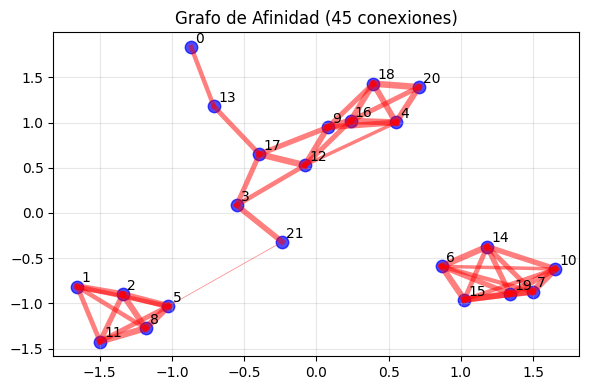

In [22]:
plt_grafo_afinidad(Dx, W)

 ## PASO 2: Calcular la Matriz Laplaciana
 Una vez obtenida la matriz de afinidad, el siguiente paso es calcular una matriz Laplaciana. Como se ha visto en la parte teórica, hay tres manera de hacerlo.

In [23]:
def laplaciano_no_normalizado(mAfinidad):
    D = np.diag(np.sum(mAfinidad, axis=1))# p7 tu codigo aqui
    return D - mAfinidad

In [24]:
def matriz_Laplaciana_normalizada(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    return I-D.dot(mAfinidad)# p8u codigo aqui

In [25]:
def matriz_Laplaciana_normalizada_simetrica(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1.0/2)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    return I-D.dot(mAfinidad).dot(D)# p9 tu codigo aqui

 ## PASO 3: Análisis espectral

In [26]:
def calcula_valores_vectores_propios(mLaplaciana, K):
    # Calcular TODOS los vectores propios
    valores_pr, vectores_pr = linalg.eig(mLaplaciana)# p10 tu codigo aqui
    # Ordenar por valor propio ascendente
    orden = valores_pr.real.argsort()
    vectores_pr = vectores_pr.real[:, orden]
    # Tomar los primeros n_clusters vectores propios
    # Omitir el primer vector propio (valor ~0)
    Dx_trans =vectores_pr[:, 1: K+1]# p11 tu codigo aqui
    return Dx_trans

## PASO 4: Clustering en el Espacio de Vectores Propios

In [27]:
def agrupamiento_espectral(Dx, K, afinidad, laplaciana, **kwargs):
    mAfinidad = afinidad(Dx, **kwargs)
    mLaplaciana = laplaciana(mAfinidad)   # p12 tu codigo aqui
    Dx_trans = calcula_valores_vectores_propios(mLaplaciana, K)# p13 tu codigo aqui
    # metodo de agrupamiento
    modelo = KMeans(n_clusters = K)
    modelo = modelo.fit(Dx_trans)
    Dyp = modelo.predict(Dx_trans)  # p14 tu codigo aqui

    return [mAfinidad, Dyp]

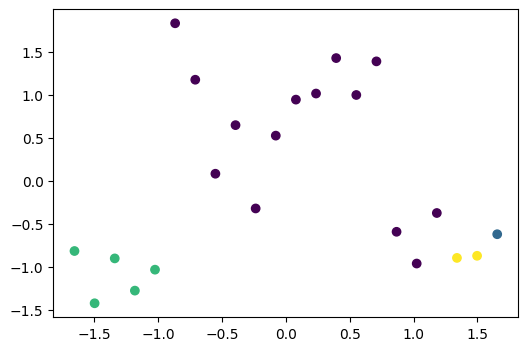

In [31]:
K = k_recomendado# p15 tu codigo aqui
epsilon= epsilon
sigma=sigma_global
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma= sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

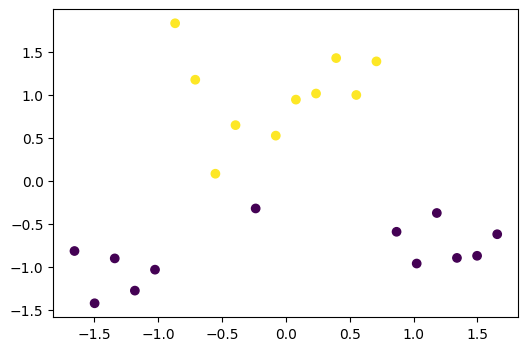

In [32]:
K = 2# p16 tu codigo aqui
epsilon=epsilon
sigma=sigma_global
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma= sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

# 🎯 **2:Pruebe el Algoritmo de Clustering Espectral**

✅ Dataset cargado desde URL GitHub


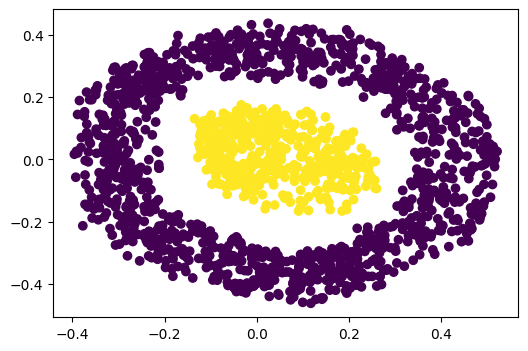

In [33]:
D =cargar_dataset("dataset_circulos_concentricos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

## Con el grafo ε-vecindad  y laplaciano no Normalizado

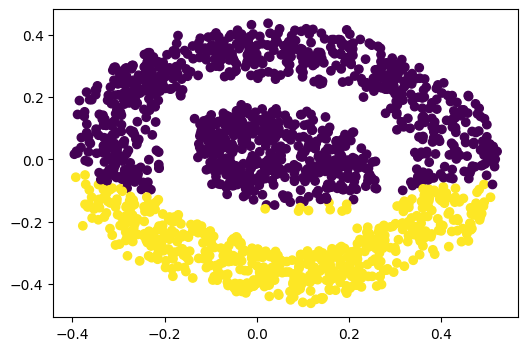

In [34]:
# p17 tu codigo aqui
K = 2
epsilon = epsilon
sigma = sigma_global

mAfinidad, Dyp = agrupamiento_espectral(
    Dx, K,
    grafo_epsilon,
    laplaciano_no_normalizado,
    epsilon=epsilon,
    sigma=sigma
)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp)


## Con El grafo k-Vecinos

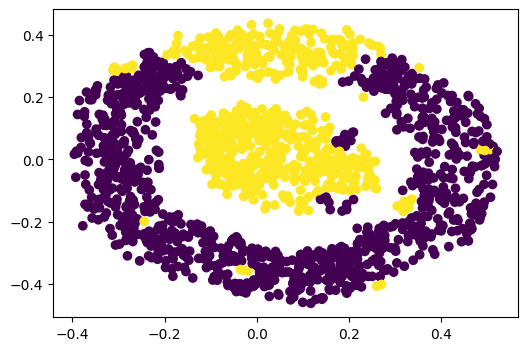

In [38]:
# p18 tu codigo aqui

K = 2
knn = k
sigma = sigma_global
modo='interseccion'

mAfinidad, Dyp = agrupamiento_espectral(
    Dx, K,
    grafo_knn,
    laplaciano_no_normalizado,
    knn=knn,
    sigma=sigma,
    modo=modo
)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp)


## Cambiado de Laplaciano


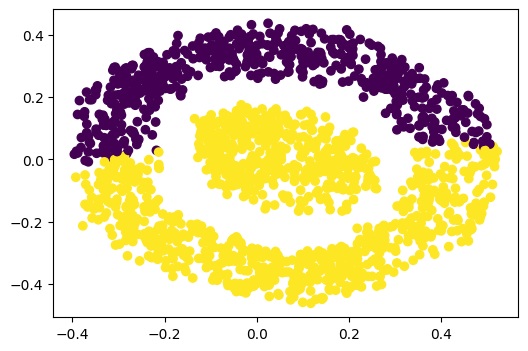

In [39]:
K = 2# p19 tu codigo aqui
knn = k
sigma= sigma_global
modo='union' ## union, interseccion, mutuo
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, matriz_Laplaciana_normalizada, knn=knn, sigma= sigma, modo= modo)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

<hr>
Experimente con el dataset dos remolinos


In [40]:
D =cargar_dataset("dataset_dos_remolinos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


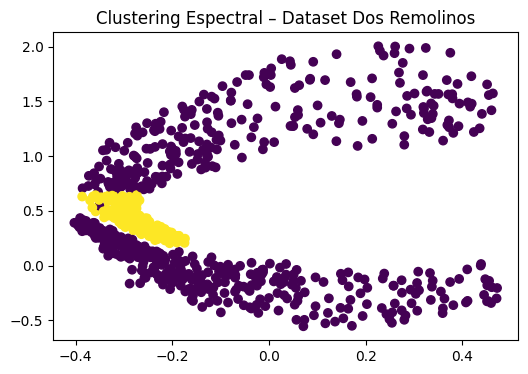

In [42]:
K = 2 # P20 tu codigo aqui
knn = 10
sigma = sigma_global
modo = 'mutuo'   # union, interseccion, mutuo

mAfinidad, Dyp = agrupamiento_espectral(
    Dx,
    K,
    grafo_knn,
    matriz_Laplaciana_normalizada_simetrica,
    knn=knn,
    sigma=sigma,
    modo=modo
)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp)
ax.set_title("Clustering Espectral – Dataset Dos Remolinos")
plt.show()


Experimente con el dataset cuatro diferente medida

In [43]:
D =cargar_dataset("dataset_cuatro_diferente_medida.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


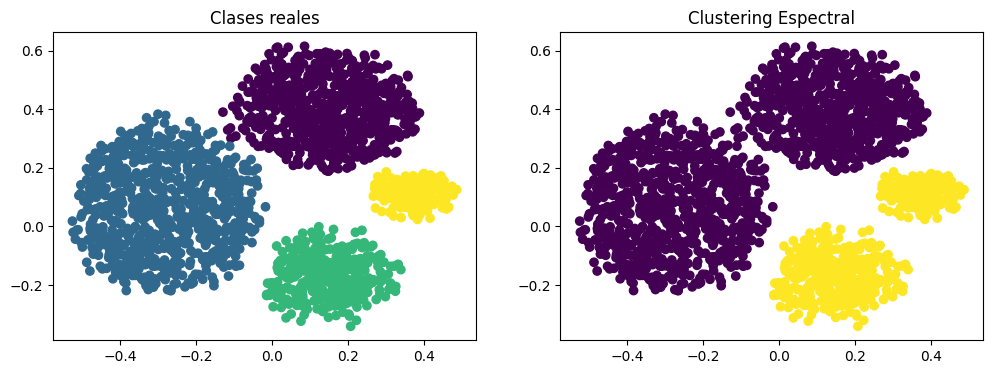

In [46]:
k=4 # p21. Complete el codigo
knn = 10
sigma = sigma_global
modo = 'union'   # union, interseccion, mutuo
mAfinidad, Dyp = agrupamiento_espectral(
    Dx,
    K,
    grafo_knn,
    matriz_Laplaciana_normalizada_simetrica,
    knn=knn,
    sigma=sigma,
    modo=modo
)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(Dx[:,0], Dx[:,1], c=Dy)
ax[0].set_title("Clases reales")

ax[1].scatter(Dx[:,0], Dx[:,1], c=Dyp)
ax[1].set_title("Clustering Espectral")

plt.show()


<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering espectral.

Están implementadas (parámetro affinity) las matrices de afinidad completa y KNN. Usa la matriz Laplaciana normalizada.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


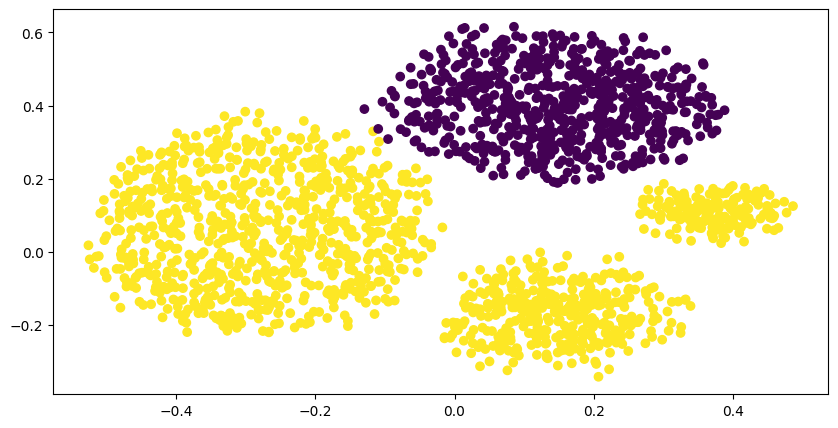

In [47]:
from sklearn.cluster import SpectralClustering
K = 2
knn = 5
clustering = SpectralClustering(n_clusters = K,
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0).fit(Dx)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)

Que metodo funciona mejor para los 5 Dataset y porque?


*   dataset_circulos_concentricos
*   dataset_cuatro_diferente_densidad
*   dataset_cuatro_separables_peque
*   dataset_cuatro_diferente_medida
*   dataset_inseparable



dataset_circulos_concentricos

✅ Dataset cargado desde URL GitHub


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


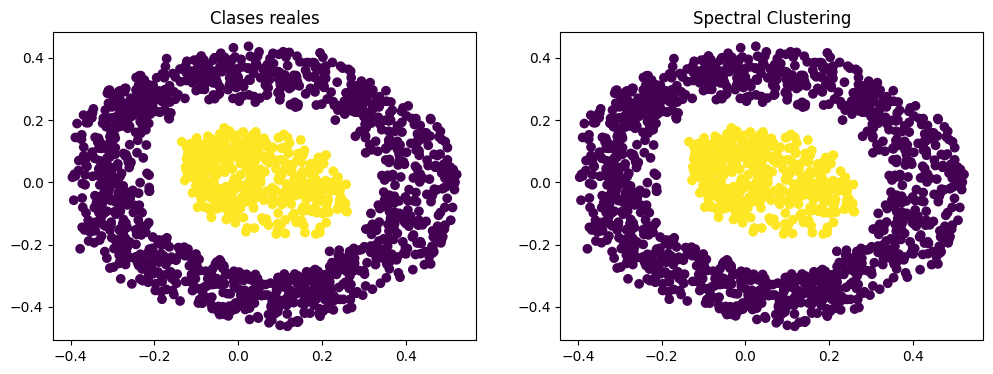

In [48]:
D = cargar_dataset("dataset_circulos_concentricos.xlsx")
D = D[np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False), :]

Dx = D[:,1:3]
Dy = D[:,3]

K = 2
knn = 5

clustering = SpectralClustering(
    n_clusters=K,
    affinity='nearest_neighbors',
    n_neighbors=knn,
    random_state=0
).fit(Dx)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(Dx[:,0], Dx[:,1], c=Dy)
ax[0].set_title("Clases reales")

ax[1].scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)
ax[1].set_title("Spectral Clustering")

plt.show()


dataset_cuatro_diferente_densidad

✅ Dataset cargado desde URL GitHub


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


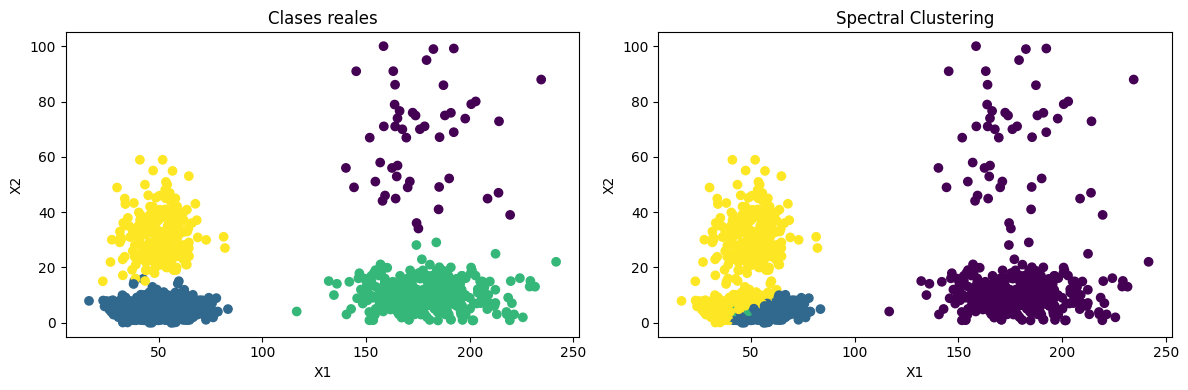

In [54]:
D = cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
D = D[np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False), :]

Dx = D[:, 0:2]
Dy = D[:, 2]


K = 4
knn = 7

clustering = SpectralClustering(
    n_clusters=K,
    affinity='nearest_neighbors',
    n_neighbors=knn,
    random_state=0
)

labels = clustering.fit_predict(Dx)


Dx_plot = Dx.copy()
Dx_plot[:, 1] = Dx_plot[:, 1] + np.random.normal(0, 0.08, size=Dx.shape[0])


fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(Dx_plot[:,0], Dx_plot[:,1], c=Dy)
ax[0].set_title("Clases reales")
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")

ax[1].scatter(Dx_plot[:,0], Dx_plot[:,1], c=labels)
ax[1].set_title("Spectral Clustering")
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")

plt.tight_layout()
plt.show()



dataset_cuatro_separables_peque

✅ Dataset cargado desde URL GitHub


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


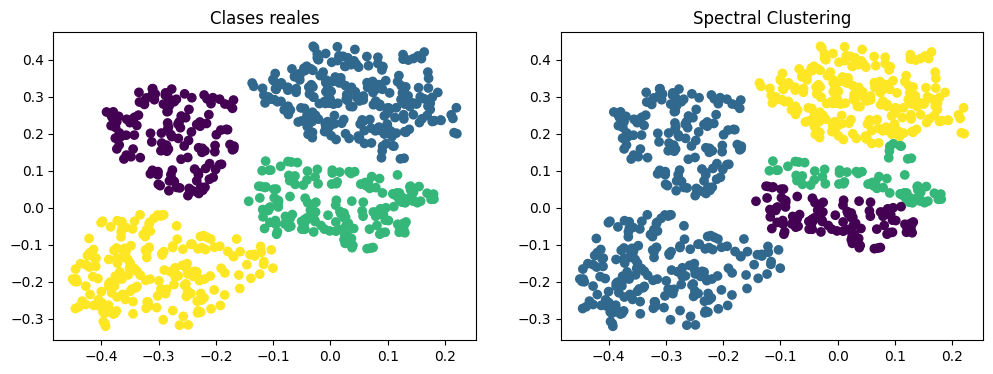

In [51]:
D = cargar_dataset("dataset_cuatro_separables_peque.xlsx")
D = D[np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False), :]

Dx = D[:,1:3]
Dy = D[:,3]

K = 4
knn = 5

clustering = SpectralClustering(
    n_clusters=K,
    affinity='nearest_neighbors',
    n_neighbors=knn,
    random_state=0
).fit(Dx)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(Dx[:,0], Dx[:,1], c=Dy)
ax[0].set_title("Clases reales")

ax[1].scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)
ax[1].set_title("Spectral Clustering")

plt.show()


dataset_cuatro_diferente_medida

✅ Dataset cargado desde URL GitHub


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


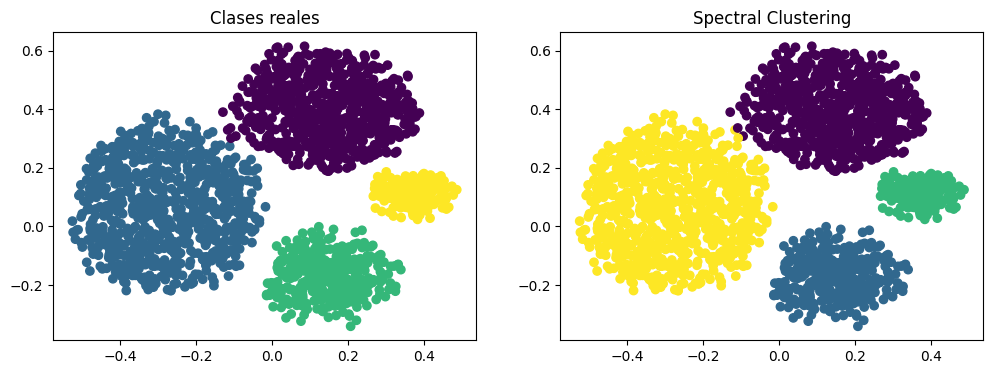

In [52]:
D = cargar_dataset("dataset_cuatro_diferente_medida.xlsx")
D = D[np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False), :]

Dx = D[:,1:3]
Dy = D[:,3]

K = 4
knn = 10

clustering = SpectralClustering(
    n_clusters=K,
    affinity='nearest_neighbors',
    n_neighbors=knn,
    random_state=0
).fit(Dx)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(Dx[:,0], Dx[:,1], c=Dy)
ax[0].set_title("Clases reales")

ax[1].scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)
ax[1].set_title("Spectral Clustering")

plt.show()


dataset_inseparable

✅ Dataset cargado desde URL GitHub


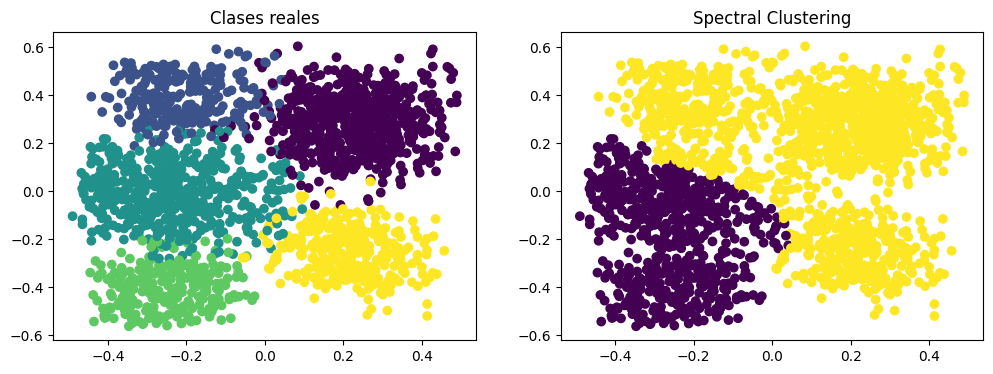

In [53]:
D = cargar_dataset("dataset_inseparable.xlsx")
D = D[np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False), :]

Dx = D[:,1:3]
Dy = D[:,3]

K = 2
knn = 8

clustering = SpectralClustering(
    n_clusters=K,
    affinity='nearest_neighbors',
    n_neighbors=knn,
    random_state=0
).fit(Dx)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(Dx[:,0], Dx[:,1], c=Dy)
ax[0].set_title("Clases reales")

ax[1].scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)
ax[1].set_title("Spectral Clustering")

plt.show()


El Clustering Espectral es el método que funciona mejor para los cinco datasets, ya que es capaz de identificar clusters con formas complejas, diferentes densidades y tamaños, además de manejar datos no separables linealmente.
Aunque K-Means es adecuado para datasets simples y bien separados, no es robusto frente a estructuras complejas, donde el Clustering Espectral demuestra un desempeño superior.

# 🚀 ¡TALLER FINALIZADO!"